In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata

In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [41]:
# read in CellRanger output data

folders = ["CID005217-1", "CID005221-1", "CID006493-1", "CID006515-1", "CID007664-1", "CID007827-1", "CID008474-1"]
adata_list = []

# read sample
for sample in folders:
    
        #sample = folders[0]
        path = 'C:/Users/saman/00_Bachelorarbeit/Bachelor/data/' + sample + '/filtered/' # TODO: change to universal path here
        adata = sc.read_mtx(
                filename= (path + 'matrix.mtx'),  # the .mtx file 
        )
        adata = adata.transpose()

        # obs = single cells and their barcodes (2312)
        # var = genes and their annotations (33808)

        adata.obs['sampleID'] = sample
        adata.obs['barcode'] = pd.read_csv((path + 'barcodes.tsv'), delimiter='\t', names=['barcode']).values
        adata.var = pd.read_csv((path + 'features.tsv'), delimiter='\t', names=['gene_ids', 'index', 'feature_types'], index_col='index')
        adata.var_names_make_unique()
        adata.obs.index = adata.obs[['sampleID', 'barcode']].agg('-'.join, axis=1)

        adata_list.append(adata)
        print(sample + " done")


CID005217-1 done
CID005221-1 done
CID006493-1 done
CID006515-1 done
CID007664-1 done
CID007827-1 done
CID008474-1 done


In [42]:
adata_list

[AnnData object with n_obs × n_vars = 2312 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 10359 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2452 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1695 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2273 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 949 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3253 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types']

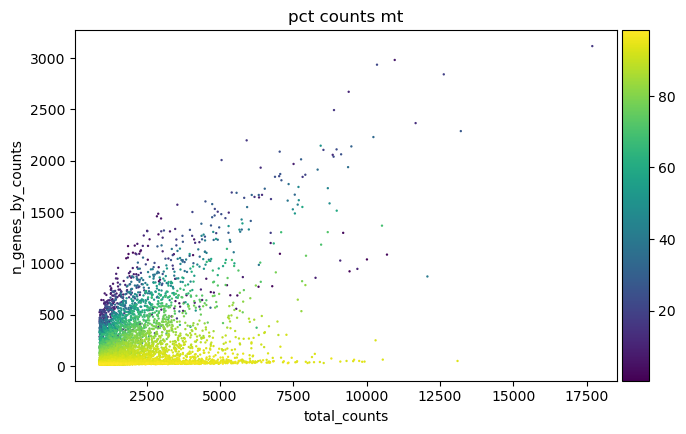

In [73]:
# mitochondrial genes
adata_list[1].var["mt"] = adata_list[1].var_names.str.startswith("MT-")
# ribosomal genes
adata_list[1].var["ribo"] = adata_list[1].var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_list[1].var["hb"] = adata_list[1].var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata_list[1], qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?
sc.pl.scatter(adata_list[1], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## SoupX 

In [7]:
# adata_pp = adata.copy()
# sc.pp.normalize_per_cell(adata_pp)
# sc.pp.log1p(adata_pp)

# sc.pp.pca(adata_pp)
# sc.pp.neighbors(adata_pp)
# sc.tl.leiden(adata_pp, key_added="soupx_groups")

# # Preprocess variables for SoupX
# soupx_groups = adata_pp.obs["soupx_groups"]


# del adata_pp


# cells = adata.obs_names
# genes = adata.var_names
# data = adata.X.T


# raw_path = '../data/qc_data/' + sample + '/Gene/raw'
# adata_raw = sc.read_10x_mtx(
#     path,  # the directory with the `.mtx` file
#     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#     cache=True) 

# adata_raw.var_names_make_unique()
# data_tod = adata_raw.X.T

In [8]:
# do SoupX ambient RNA removal here

## Doublet Detection

In [5]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
%%R
install.packages("scDblFinder")

--- Please select a CRAN mirror for use in this session ---


In [6]:
for sample in range(len(adata_list)):
    data_mat = adata_list[sample].X.T
    %R -i data_mat
    %R set.seed(123)
    %R sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))
    %R doublet_score = sce$scDblFinder.score
    doublet_score = ro.globalenv['doublet_score']
    #print(doublet_score)
    adata_list[sample].obs['doublet_score'] = doublet_score

adata_list[0].obs.columns


Error in as(counts(sce), "dgCMatrix") : 
  no method or default for coercing "dgRMatrix" to "dgCMatrix"


RInterpreterError: Failed to parse and evaluate line 'sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))'.
R error message: 'Error in as(counts(sce), "dgCMatrix") : \n  no method or default for coercing "dgRMatrix" to "dgCMatrix"'

## Calculation of QC metrics per sample

In [43]:
# outlier threshold definition
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    lower = np.median(M) - nmads * (M - M.mean()).abs().mean()
    upper = np.median(M) + nmads * (M - M.mean()).abs().mean()
    outlier = (M < lower) | (upper < M)
    return outlier, lower, upper


def all_qc_metrics(adata, remove_genes=True):

    metrics = {}
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    # calculate QC metrics now

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?

# TODO: PLOTS FOR EACH SAMPLE BEFORE CORRECTING QC !!!
# TODO: remove high value outliers? 0.995 upper percentile
    
    # filter outliers 
    tc_outliers, metrics['tc_lower'], metrics['tc_upper'] = is_outlier(adata, "log1p_total_counts", 5)
    ng_outliers, metrics['ng_lower'], metrics['ng_upper'] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
    top20_outliers, metrics['top20_lower'], metrics['top20_upper'] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    adata.obs["outlier"] = (tc_outliers | ng_outliers | top20_outliers)
    
    temp_cell = 0
    if (len(adata.obs.outlier.value_counts()) > 1):
        temp_cell = adata.obs.outlier.value_counts()[1]
    metrics['n_cell_outlier'] = temp_cell

    # filter out high mitochondrial percent cells
    mt_outlier, metrics['mt_lower'], metrics['mt_upper'] = is_outlier(adata, "pct_counts_mt", 3) 
    adata.obs["mt_outlier"] = mt_outlier | ( adata.obs["pct_counts_mt"] > 25) # adjusable value, 25 is permissable

    temp_mt = 0
    if (len(adata.obs.mt_outlier.value_counts()) > 1):
        temp_mt = adata.obs.mt_outlier.value_counts()[1]
    metrics['n_mt_outliers'] = temp_mt

    # summary of removed cells
    metrics['n_cells_before'] = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    metrics['n_cells_after'] = adata.n_obs

    metrics['n_genes_before'] = adata.n_vars
    if remove_genes:
        # filter out low count genes
        
        # Min 20 cells - filters out 0 count genes
        sc.pp.filter_genes(adata, min_cells=20)
        gene_subset, number_per_gene = sc.pp.filter_genes(adata, min_cells=20, inplace=False)
        #adata.var['gene_subset'] = gene_subset
        #adata.var['number_per_gene'] = number_per_gene
    metrics['n_genes_after'] = adata.n_vars

    return adata, metrics

In [44]:
list_metrics = []
adatas_qced = []

for sample in adata_list:
    adata, metric = all_qc_metrics(sample)
    list_metrics.append(list(pd.Series(metric.values())))
    adatas_qced.append(adata)

In [45]:
df_metrics = pd.DataFrame(data = list_metrics, columns = ["tc_lower", "tc_upper", "ng_lower", "ng_upper", "top20_lower", "top20_upper", "n_cell_outlier", "mt_lower", "mt_upper", "n_mt_outliers",
    "n_cells_before", "n_cells_after", "n_genes_before", "n_genes_after"], index=folders)

df_metrics

# LOOK INTO SAMPLE 5221

,tc_lower,tc_upper,ng_lower,ng_upper,top20_lower,top20_upper,n_cell_outlier,mt_lower,mt_upper,n_mt_outliers,n_cells_before,n_cells_after,n_genes_before,n_genes_after
CID005217-1,6.614544,11.930395,5.153028,10.645279,-39.918747,130.192890,45.0,-14.458876,91.659132,477.0,2312.0,477.0,33808.0,11669.0
CID005221-1,5.376746,9.194267,-1.273096,8.325817,48.173741,150.224428,422.0,54.580342,131.275172,0.0,10359.0,0.0,33808.0,0.0
CID006493-1,6.497736,10.489908,3.479385,11.082009,-93.935042,152.512547,28.0,-69.821949,96.777821,873.0,2452.0,1561.0,33808.0,13328.0
CID006515-1,6.067164,11.687042,5.648118,9.682451,-41.550147,89.571512,24.0,-30.417998,52.925185,437.0,1695.0,1258.0,33808.0,13204.0
CID007664-1,6.560970,11.557833,4.666738,10.319897,-44.704622,149.345590,40.0,-47.412933,82.189301,832.0,2273.0,1441.0,33808.0,13546.0
CID007827-1,6.957418,12.123309,5.132477,10.394416,-62.583230,145.885736,7.0,-37.027208,63.453943,269.0,949.0,680.0,33808.0,12708.0
CID008474-1,7.345757,11.812387,5.756858,10.314995,-54.654893,121.473950,5.0,-21.757519,56.526844,1029.0,3253.0,2224.0,33808.0,14947.0


In [46]:
adatas_qced.pop(1) # remove weird 5221 sample (for now)
adatas_qced

[AnnData object with n_obs × n_vars = 477 × 11669
     obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells',
 AnnData object with n_obs × n_vars = 1561 × 13328
     obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'

In [47]:
# concat all sample anndata objects into one
adata = anndata.concat(adatas_qced)
adata

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'

In [ ]:
# inner vs outer join: 
# outer join -> 15844 genes (num of genes with at least 20 cells in one sample)
# inner join -> 10962 genes (num of genes with at least 20 cells in every sample)

# number of genes with at least 20 cells in any sample: 17893

In [32]:
# remove low counts genes over all samples
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 7641 × 17893
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells'

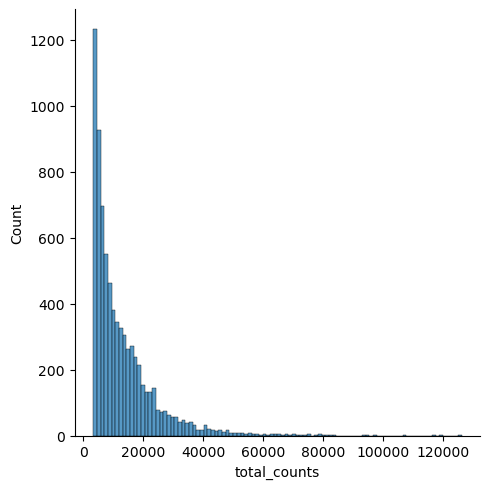

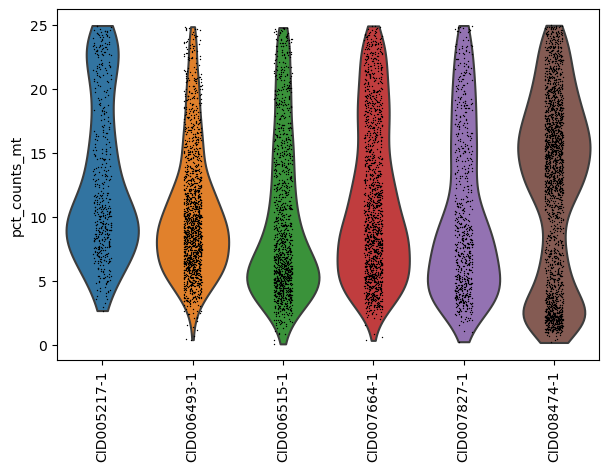

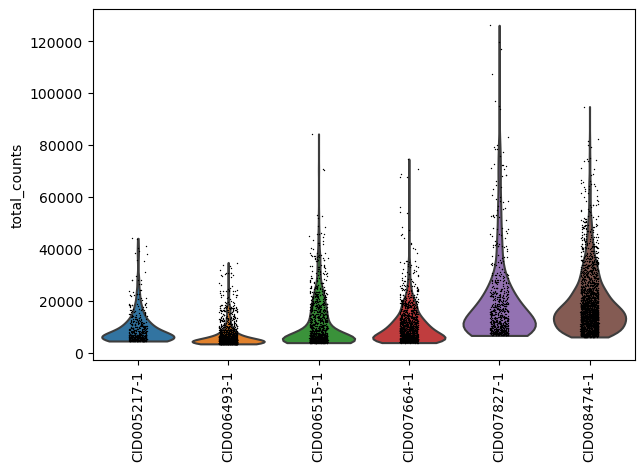

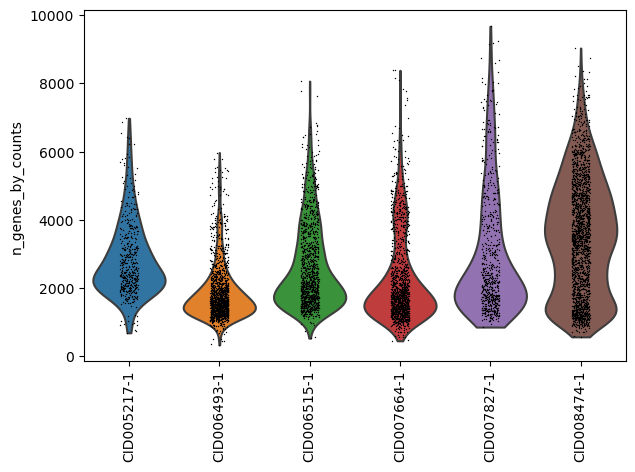

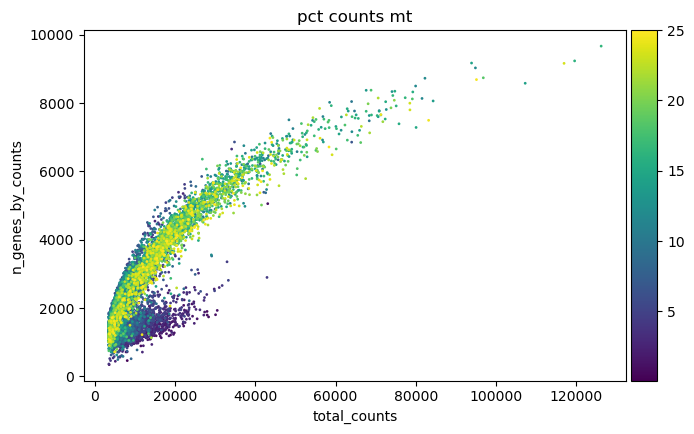

In [48]:
# plotting QC metrics AFTER QC CORRECTION ON EACH SAMPLE INDIVIDUALLY

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt", groupby= "sampleID", rotation=90)
p3 = sc.pl.violin(adata, "total_counts", groupby= "sampleID", rotation=90)
p4 = sc.pl.violin(adata, "n_genes_by_counts", groupby= "sampleID", rotation=90)
p5 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
#p6 = sns.displot(adata.obs["doublet_score"], bins=100, kde=False)

In [34]:
# write raw data to file for scvi integration

adata.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_raw.h5ad"
)

## TC Normalization

In [49]:
# save unnormalized data to inspect effect and save raw data
adata_notnorm = adata.copy()

In [50]:
# normalize and log1p fitting

# proportional fitting to mean of cell depth
sc.pp.normalize_total(adata, target_sum=None)
adata_notnorm.layers["total_counts_norm"] = adata.X
adata_notnorm

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    uns: 'sampleID_colors'
    layers: 'total_counts_norm'

In [51]:
# log1p transform
sc.pp.log1p(adata)
adata_notnorm.layers["tc_norm_log"] = adata.X
adata_notnorm

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    uns: 'sampleID_colors'
    layers: 'total_counts_norm', 'tc_norm_log'

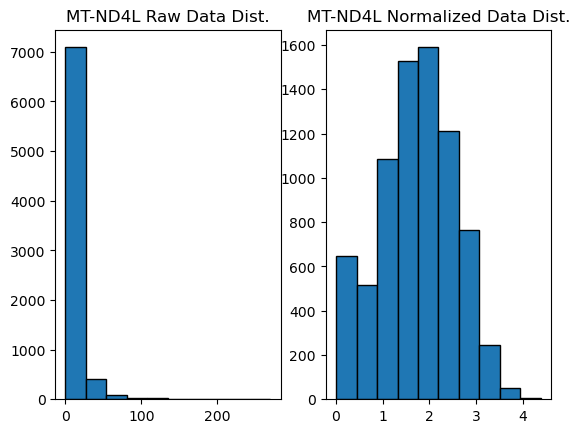

In [40]:
# show effect of normalization
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(adata_notnorm.to_df()["MT-ND4L"], edgecolor="black")
ax1.set_title('MT-ND4L Raw Data Dist.')
ax2.hist(adata.to_df()["MT-ND4L"], edgecolor="black")
ax2.set_title('MT-ND4L Normalized Data Dist.')
plt.show()

In [59]:
# read in integrated normalized expression 

adata_int = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_integrated.h5ad")
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'integrated'
    obsp: 'connectivities', 'distances'

In [60]:
adata_int.layers['int_norm'] = adata_int.layers['integrated']
del adata_int.layers["integrated"]
temp = sc.pp.log1p(adata_int, layer='int_norm', copy=True)
adata_int.layers['int_norm_log'] = temp.layers['int_norm']
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'int_norm', 'int_norm_log'
    obsp: 'connectivities', 'distances'

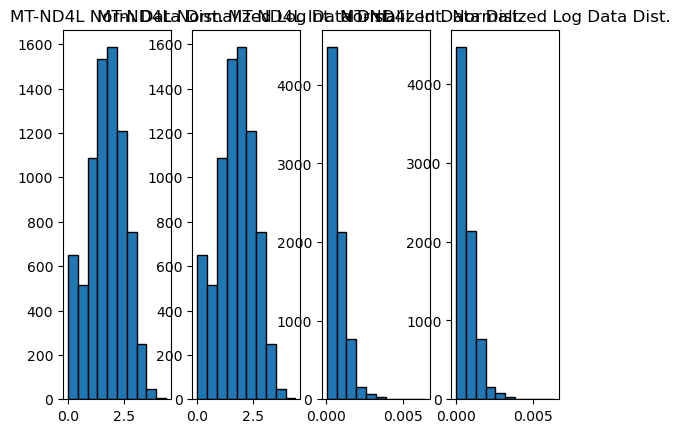

In [61]:
# show effect 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(adata_notnorm.to_df(layer='total_counts_norm')["MT-ND4L"], edgecolor="black")
ax1.set_title('MT-ND4L Norm Data Dist.')
ax2.hist(adata_notnorm.to_df(layer='tc_norm_log')["MT-ND4L"], edgecolor="black")
ax2.set_title('MT-ND4L Normalized Log Data Dist.')
ax3.hist(adata_int.to_df(layer='int_norm')["MT-ND4L"], edgecolor="black")
ax3.set_title('MT-ND4L Int. Normalized Data Dist.')
ax4.hist(adata_int.to_df(layer='int_norm_log')["MT-ND4L"], edgecolor="black")
ax4.set_title('MT-ND4L Int. Normalized Log Data Dist.')
plt.show()

In [62]:
adata_int.layers['tc_norm'] = adata_notnorm.layers['total_counts_norm']
adata_int.layers['tc_norm_log'] = adata_notnorm.layers['tc_norm_log']
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'int_norm', 'int_norm_log', 'tc_norm', 'tc_norm_log'
    obsp: 'connectivities', 'distances'

In [63]:
adata_int.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_norms.h5ad"
)

## Method to run through batch-wise HVGS and dim. reduction automatically

In [19]:
# function to select batch key and perform HVG selection, PCA, and UMAP on this subset

def batch_reduction(adata, batch_key=None):
    temp = adata.copy()
    # HVG selection using inputted batch key
    sc.pp.highly_variable_genes(temp, n_top_genes=2000, batch_key=batch_key, subset=True)

    # dimensionality reduction
    sc.pp.pca(temp, n_comps=50, svd_solver="arpack") #PCA
    sc.pp.neighbors(temp)
    sc.tl.umap(temp) # UMAP

    return temp

In [20]:
adata_new = batch_reduction(adata)
adata_new

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [21]:
adata_sample_batch = batch_reduction(adata, "sampleID")
adata_sample_batch

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarnin

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
# clean up adata_int to only contain normalized integrated matrix
adata_int.X = adata_int.layers['integrated']
del adata_int.layers["integrated"]
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [25]:
adata_int_new = batch_reduction(adata_int)
adata_int_new

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap', 'hvg', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


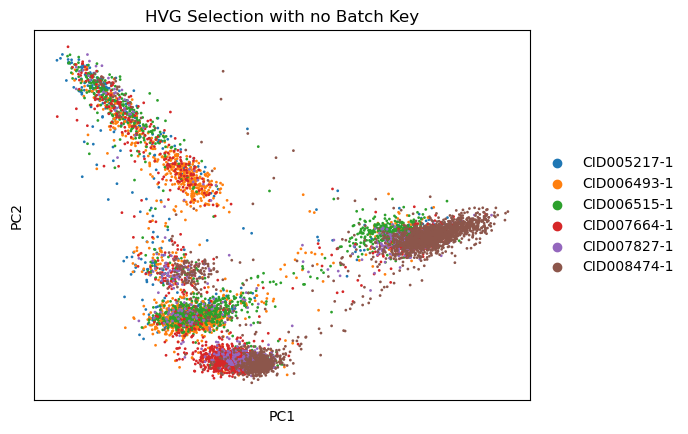

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


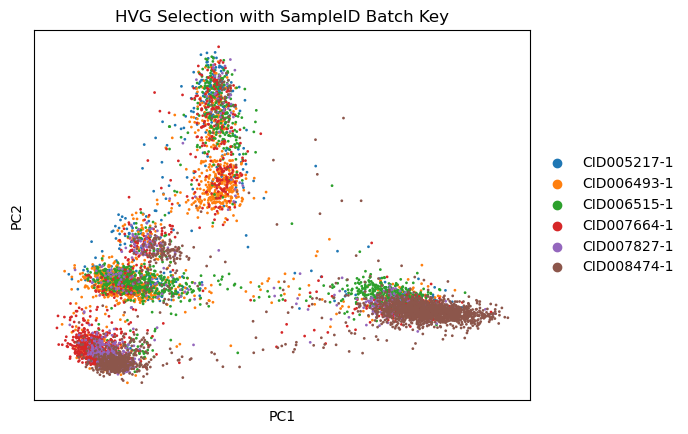

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


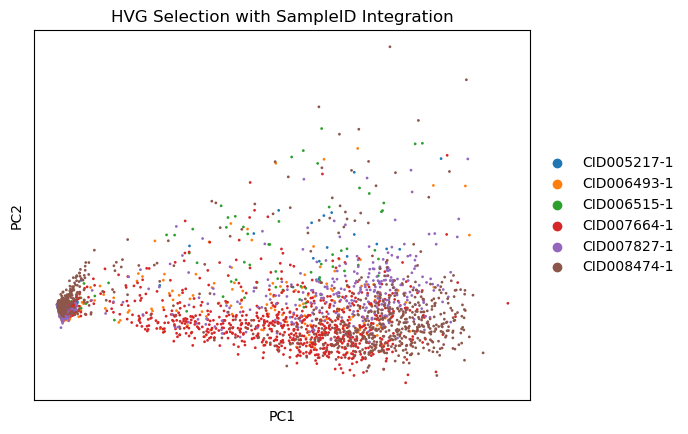

In [27]:
color = "sampleID"

pca1 = sc.pl.pca_scatter(adata_new, color=color, title="HVG Selection with no Batch Key")

pca2 = sc.pl.pca_scatter(adata_sample_batch, color=color, title="HVG Selection with SampleID Batch Key")

pca3 = sc.pl.pca_scatter(adata_int_new, color=color, title="HVG Selection with SampleID Integration")

## UMAPs

In [28]:
# UMAPs
sc.tl.umap(adata_new)

sc.tl.umap(adata_sample_batch)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


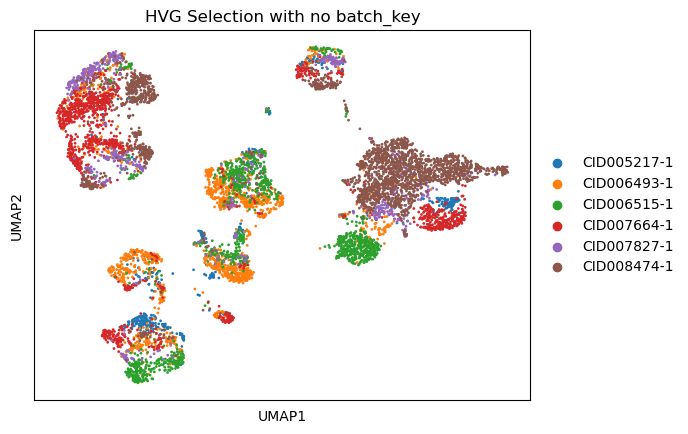

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


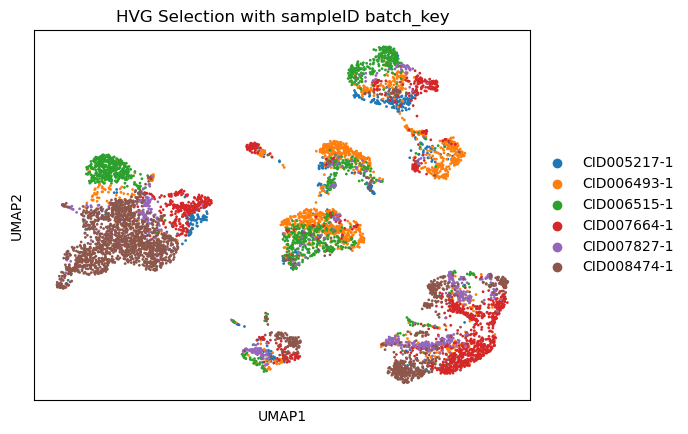

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


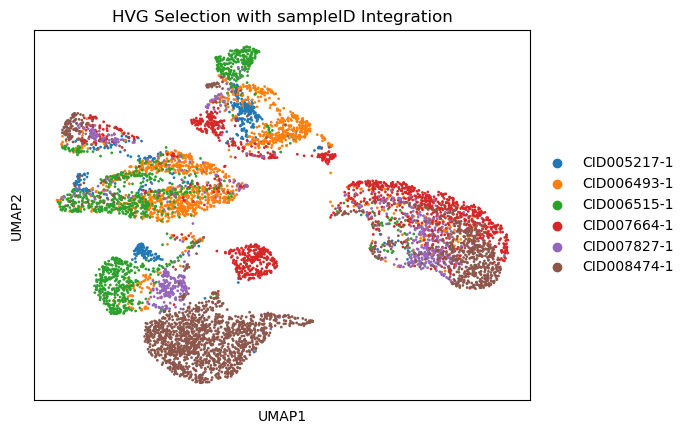

In [29]:
# color by corresponding batch var 

umap1 = sc.pl.umap(adata_new, color=color, title='HVG Selection with no batch_key') 
umap2 = sc.pl.umap(adata_sample_batch, color=color, title='HVG Selection with sampleID batch_key')
umap3 = sc.pl.umap(adata_int_new, color=color, title='HVG Selection with sampleID Integration')

In [28]:
# write data so far to file

#import hdf5plugin

adata_new.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_preprocessed.h5ad"
)

adata_sample_batch.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_preprocessed_samplebatch.h5ad"
)